In [1]:
import pandas as pd
import os
import numpy as np
import pickle
import json
import scipy
import matplotlib.pyplot as plt
import shutil
from skimage.measure import regionprops
import cv2 as cv
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import sys
import string
from PIL import Image
from scipy import signal
from scipy.interpolate import interp1d
from skimage import measure
import seaborn as sns
from scipy import stats
from skimage.draw import rectangle
import importlib
import splitfolders
from scipy.stats import gaussian_kde
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


import plots
import df_utils
importlib.reload(df_utils)
import features
import Figure2plots
importlib.reload(Figure2plots)

<module 'Figure2plots' from 'C:\\Users\\codyt\\Documents\\repos\\time-series-dc\\Figure2plots.py'>

In [2]:
df = pd.read_pickle('D://Datasets//FINAL_DF_light')
df = df_utils.filter_df(df,ymax=5,max_ar=1.1,radius_std=3)
df = df[(df.cell=='hl60')|(df.cell=='hl60d')]
df = df[np.logical_not((df.cell=='hl60')&(df.date=='11-3-20')&(df.run=='0'))]
df = df[np.logical_not((df.cell=='hl60')&(df.date=='11-5-20')&(df.run=='3'))]
print(len(df))

Length prefilter: 2337
Length postfilter: 1925
1501


In [3]:
df.columns

Index(['event', 'tf', 'perimeter', 'area', 'circ', 'deform', 'r_um', 'xcm_um',
       'yc_um', 'perimeter_cx', 'area_cx', 'circ_cx', 'deform_cx', 'r_um_cx',
       'xc_um_el', 'yc_um_el', 'a', 'b', 'aspect', 'r_um_el', 'cell', 'date',
       'run', 'r_idx', 'nar1_idx', 'nar2_idx', 'cav_idx', 'out1_idx',
       'out2_idx', 'rad', 'nar1_def', 'nar2_def', 'cav1_def', 'r_el',
       'nar1_asp', 'nar2_asp', 'cav1_asp', 'nar1_per', 'nar2_per', 'cav1_per',
       'nar1_area', 'nar2_area', 'cav1_area', 'nar1_max_arg', 'nar2_max_arg',
       'cav1_min_arg', 'x_poly1', 'x_poly2', 'x_poly3', 'region1_dx',
       'region1_dt', 'region1_dasp', 'delta_asp', 'v_avg', 'mean_area',
       'mean_perimeter', 'mean_aspect', 'r1_slope', 'r2_slope', 'r3_slope',
       'r1_int', 'r2_int', 'r3_int'],
      dtype='object')

C:\Users\codyt\.conda\envs\aktwelve\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\codyt\.conda\envs\aktwelve\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='nar1_asp', ylabel='Density'>

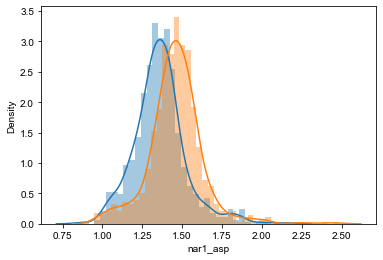

In [4]:
sns.distplot(df[df.cell=='hl60'].nar1_asp)
sns.distplot(df[df.cell=='hl60d'].nar1_asp)

In [18]:
feature_list = ['nar1_asp', 'nar2_asp', 'rad']

# Extract features
x = df[feature_list].to_numpy()
y = df.cell.astype('category').cat.codes.to_numpy()

# Normalize and standardize first
scalar = sklearn.preprocessing.StandardScaler()
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=123)

# Fit scalar on training, apply transformation to val/test
scalar.fit(x_train)
x_train = scalar.transform(x_train)
x_val = scalar.transform(x_val)

x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=123)

In [19]:
clf = KNeighborsClassifier()
clf.fit(x_train, y_train.ravel())

KNeighborsClassifier()

In [20]:
clf.score(x_val, y_val)

0.6711111111111111

In [23]:
list(itertools.combinations(feature_list, 1))[0][0]

'nar1_asp'

In [21]:
feature_list = ['nar1_asp', 'nar2_asp', 'rad','r1_slope','delta_asp']
label = []
score = []
auc = []
aic = []

for i in range(len(feature_list)):
    
    sub_feats = list(itertools.combinations(feature_list, i+1))
    
    for j,feats in enumerate(sub_feats):
        x = df[list(feats)].to_numpy()
        y = df.cell.astype('category').cat.codes.to_numpy()
        
        # Normalize and standardize first
        scalar = sklearn.preprocessing.StandardScaler()
        x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=123)

        # Fit scalar on training, apply transformation to val/test
        scalar.fit(x_train)
        x_train = scalar.transform(x_train)
        x_val = scalar.transform(x_val)
        
        clf = KNeighborsClassifier(n_neighbors=10)
        clf.fit(x_train, y_train.ravel())
        
        score.append(clf.score(x_val, y_val))
        label.append(list(feats))
        
        auc.append(roc_auc_score(y_val, clf.predict_proba(x_val)[:,1]))
        
        #y_hat = logreg.predict(x_val)
        #resid = y_val - y_hat
        #sse = sum(resid**2)
        #k= 2
        #AIC= 2*k - 2*np.log(sse)
        #aic.append(AIC)
        
print(np.max(auc))
print(label[np.argmax(auc)])
print(score[np.argmax(auc)])

0.793537281133189
['nar2_asp', 'rad', 'r1_slope', 'delta_asp']
0.738359201773836


In [53]:
df[feature_list[0]].to_numpy().reshape(-1,1)

array([[1.21066693],
       [1.86547244],
       [1.11118088],
       ...,
       [1.70440443],
       [1.39108262],
       [1.48836547]])

In [8]:
with open('./sklearn_models/feature_list.txt', 'r') as file:
    feats = json.load(file)

feature_dict = feats
feature_list = list(feature_dict)
feature_list_cleaned = [feature_dict[i] for i in list(feature_dict.keys())]

In [9]:
#feature_list = ['nar1_asp', 'nar2_asp','r1_slope','r2_slope','delta_asp']
label = []
score = []
auc = []
aic = []

for i in range(len(feature_list)):
    
    
    x = df[feature_list[i]].to_numpy()
    y = df.cell.astype('category').cat.codes.to_numpy()

    # Normalize and standardize first
    scalar = sklearn.preprocessing.StandardScaler()
    x_train, x_val, y_train, y_val = train_test_split(x.reshape(-1,1), y, test_size=0.3, random_state=123)

    # Fit scalar on training, apply transformation to val/test
    scalar.fit(x_train)
    x_train = scalar.transform(x_train)
    x_val = scalar.transform(x_val)

    logreg = LogisticRegression()
    logreg.fit(x_train,y_train)

    score.append(logreg.score(x_val, y_val))
    label.append(feature_list[i])

    auc.append(roc_auc_score(y_val, logreg.predict_proba(x_val)[:,1]))
        
    #y_hat = logreg.predict(x_val)
    #resid = y_val - y_hat
    #sse = sum(resid**2)
    #k= 2
    #AIC= 2*k - 2*np.log(sse)
    #aic.append(AIC)

print(np.max(auc))
print(label[np.argmax(auc)])
print(score[np.argmax(auc)])

0.7480818414322251
nar1_asp
0.7161862527716186


In [10]:
list(zip(np.array(score),np.array(label)))

[(0.5720620842572062, 'rad'),
 (0.7161862527716186, 'nar1_asp'),
 (0.6940133037694013, 'nar2_asp'),
 (0.5898004434589801, 'nar1_per'),
 (0.5742793791574279, 'nar2_per'),
 (0.6008869179600886, 'nar1_area'),
 (0.5698447893569845, 'nar2_area'),
 (0.5920177383592018, 'delta_asp'),
 (0.70509977827051, 'r1_slope'),
 (0.6385809312638581, 'r2_slope')]

In [11]:
feature_list_cleaned

['Radius',
 'R1 AR',
 'R3 AR',
 'R1 Per',
 'R3 Per',
 'R1 Area',
 'R3 Area',
 'R1-R3 AR',
 'R2 Slope',
 'R3 Slope']

In [25]:
feature_list = ['nar1_asp', 'nar2_asp', 'rad','r1_slope','delta_asp']
label = []
score = []
auc = []
aic = []

for i in range(len(feature_list)):
    
    sub_feats = list(itertools.combinations(feature_list, i+1))
    
    for j,feats in enumerate(sub_feats):
        x = df[list(feats)].to_numpy()
        y = df.cell.astype('category').cat.codes.to_numpy()
        
        # Normalize and standardize first
        scalar = sklearn.preprocessing.StandardScaler()
        x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=123)

        # Fit scalar on training, apply transformation to val/test
        scalar.fit(x_train)
        x_train = scalar.transform(x_train)
        x_val = scalar.transform(x_val)
        
        logreg = LogisticRegression()
        logreg.fit(x_train,y_train)
        
        score.append(logreg.score(x_val, y_val))
        label.append(list(feats))
        
        auc.append(roc_auc_score(y_val, logreg.predict_proba(x_val)[:,1]))
        
        #y_hat = logreg.predict(x_val)
        #resid = y_val - y_hat
        #sse = sum(resid**2)
        #k= 2
        #AIC= 2*k - 2*np.log(sse)
        #aic.append(AIC)

print(np.max(auc))
print(label[np.argmax(auc)])
print(score[np.argmax(auc)])

0.7754672437536887
['nar1_asp', 'rad', 'r1_slope']
0.7161862527716186


In [44]:
np.array(label)

array([list(['nar1_asp']), list(['nar2_asp']), list(['rad']),
       list(['r1_slope']), list(['delta_asp']),
       list(['nar1_asp', 'nar2_asp']), list(['nar1_asp', 'rad']),
       list(['nar1_asp', 'r1_slope']), list(['nar1_asp', 'delta_asp']),
       list(['nar2_asp', 'rad']), list(['nar2_asp', 'r1_slope']),
       list(['nar2_asp', 'delta_asp']), list(['rad', 'r1_slope']),
       list(['rad', 'delta_asp']), list(['r1_slope', 'delta_asp']),
       list(['nar1_asp', 'nar2_asp', 'rad']),
       list(['nar1_asp', 'nar2_asp', 'r1_slope']),
       list(['nar1_asp', 'nar2_asp', 'delta_asp']),
       list(['nar1_asp', 'rad', 'r1_slope']),
       list(['nar1_asp', 'rad', 'delta_asp']),
       list(['nar1_asp', 'r1_slope', 'delta_asp']),
       list(['nar2_asp', 'rad', 'r1_slope']),
       list(['nar2_asp', 'rad', 'delta_asp']),
       list(['nar2_asp', 'r1_slope', 'delta_asp']),
       list(['rad', 'r1_slope', 'delta_asp']),
       list(['nar1_asp', 'nar2_asp', 'rad', 'r1_slope']),
       

In [45]:
list(zip(np.array(score)[np.argsort(score)],np.array(label)[np.argsort(score)]))

[(0.5720620842572062, ['rad']),
 (0.5920177383592018, ['delta_asp']),
 (0.6297117516629712, ['rad', 'delta_asp']),
 (0.6585365853658537, ['nar1_asp', 'nar2_asp', 'rad']),
 (0.6607538802660754, ['nar1_asp', 'rad', 'delta_asp']),
 (0.6607538802660754, ['nar1_asp', 'nar2_asp', 'rad', 'delta_asp']),
 (0.6607538802660754, ['nar2_asp', 'rad', 'delta_asp']),
 (0.6762749445676275, ['nar2_asp', 'rad']),
 (0.6784922394678492, ['nar1_asp', 'rad']),
 (0.6807095343680709, ['nar1_asp', 'delta_asp']),
 (0.6807095343680709, ['nar1_asp', 'nar2_asp']),
 (0.6807095343680709, ['r1_slope', 'delta_asp']),
 (0.6807095343680709, ['nar1_asp', 'nar2_asp', 'delta_asp']),
 (0.6807095343680709, ['nar2_asp', 'delta_asp']),
 (0.6940133037694013, ['rad', 'r1_slope', 'delta_asp']),
 (0.6940133037694013, ['nar2_asp']),
 (0.7006651884700665, ['nar1_asp', 'nar2_asp', 'r1_slope', 'delta_asp']),
 (0.7006651884700665, ['nar2_asp', 'r1_slope', 'delta_asp']),
 (0.7006651884700665, ['nar1_asp', 'nar2_asp', 'r1_slope']),
 (0.70

In [64]:
label[np.argmax(auc)]

['nar1_asp', 'rad', 'r1_slope']

In [65]:
score[np.argmax(auc)]

0.6723404255319149

In [ ]:
def knn_search(feats)

    # Extract features
    x = df[feature_list].to_numpy()
    y = df[['y']].to_numpy()

    # Normalize and standardize first
    scalar = sklearn.preprocessing.StandardScaler()
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=123)

    # Fit scalar on training, apply transformation to val/test
    scalar.fit(x_train)
    x_train = scalar.transform(x_train)
    x_val = scalar.transform(x_val)

    x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=123)

    # Grid search all hyperparameters
    leaf_size = list(range(1, 200, 5))
    neighbors = np.arange(1, 25)
    score = {}
    for leaf in leaf_size:
        for n in neighbors:
            clf = KNeighborsClassifier(n_neighbors=n, leaf_size=leaf)
            clf.fit(x_train, y_train.ravel())
            score[(str(n), str(leaf))] = clf.score(x_val, y_val)

    # Select best weights
    n, leaf = max(score, key=lambda key: score[key])

    print('Optimized hyper params:')
    print('N: ', n, '\n', 'Leaf size: ', leaf)
    clf = KNeighborsClassifier(n_neighbors=int(n), leaf_size=int(leaf))
    clf.fit(x_train, y_train.ravel())
    print(clf.score(x_test, y_test))

    sklearn.metrics.plot_roc_curve(clf, x_test, y_test)
    plt.title('k Nearest Neighbors' + ' K: ' + str(n) + ' Leaf Size: ' + str(leaf))
    plt.savefig('knn_roc.png', dpi=300)

    pickle.dump(clf, open('knn.pkl', 'wb'))